In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import librosa
import os

Data processing parameters 

In [2]:
fs = 44100                  # Hz, sampling frequency
f_size = 512                # Frame size
h_size = int(f_size/2)      # Hop size
supra_frame_duration = 0.5  # seconds
frame_num_gl = round(supra_frame_duration / (h_size/fs))
data = np.zeros((100, h_size, frame_num_gl))

In [3]:
dir_HC = 'wav'+ os.sep + 'HC' + os.sep
dir_ALS = 'wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

Subroutine: spectrum calculation (short-time fourier transform)

In [4]:
def stft_analysis(x, f_size, h_size):
    Ln = x.shape[0]                                 # signal length
    frame_num = math.floor((Ln-f_size)/h_size + 1)  # number of frames      

    wnd = np.hamming(f_size)

    spec = np.zeros((h_size,frame_num))

    for N in range(frame_num):
        x_frame = x[h_size*N: h_size*N + f_size]
        x_wnd = x_frame*wnd

        X = np.fft.fft(x_wnd)
        X_abs = np.abs(X[0:h_size])

        spec[:,N] = np.log(X_abs)
    return spec

Analysing cycle

In [5]:
# freq = np.linspace(0, sr/2, h_size)
X = np.zeros((50000,h_size,frame_num_gl))   # data
y = np.zeros((50000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):
    if directory_HC[i][4]=='a':
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_stft = stft_analysis(x, f_size, h_size)    
        frame_num = X_stft.shape[1]
    
        # plt.subplots(dpi=150)
        # plt.pcolor(X[0:100,:],shading='flat',cmap='jet')
        # plt.xlabel('Номер фрейма')
        # plt.ylabel('$\log(|X(k,m)|)$')
     
#       #Запись фрагметов спектра в трехмерный массив 
        N_supra_frames = frame_num - frame_num_gl + 1
        for n in range(N_supra_frames):
            X[X_global_index,:,:] = X_stft[:,n:n+frame_num_gl]
            X_ids.append(int(directory_HC[i][0:3]))
            y[X_global_index] = 0
            X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][4]=='a':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_stft = stft_analysis(x, f_size, h_size)    
        frame_num = X_stft.shape[1]
     
#       #Запись фрагметов спектра в трехмерный массив 
        N_supra_frames = frame_num - frame_num_gl + 1
        for n in range(N_supra_frames):
            X[X_global_index,:,:] = X_stft[:,n:n+frame_num_gl]
            X_ids.append(int(directory_ALS[i][0:3]))
            y[X_global_index] = 1
            X_global_index = X_global_index + 1


Data for training

In [6]:
inds_to_delete = np.array(range(y.shape[0]))>=X_global_index
y = np.delete(y,inds_to_delete)
X = np.delete(X,inds_to_delete, axis=0)

Show general sample from dataset

Text(0, 0.5, '$\\log(|X(k,m)|)$')

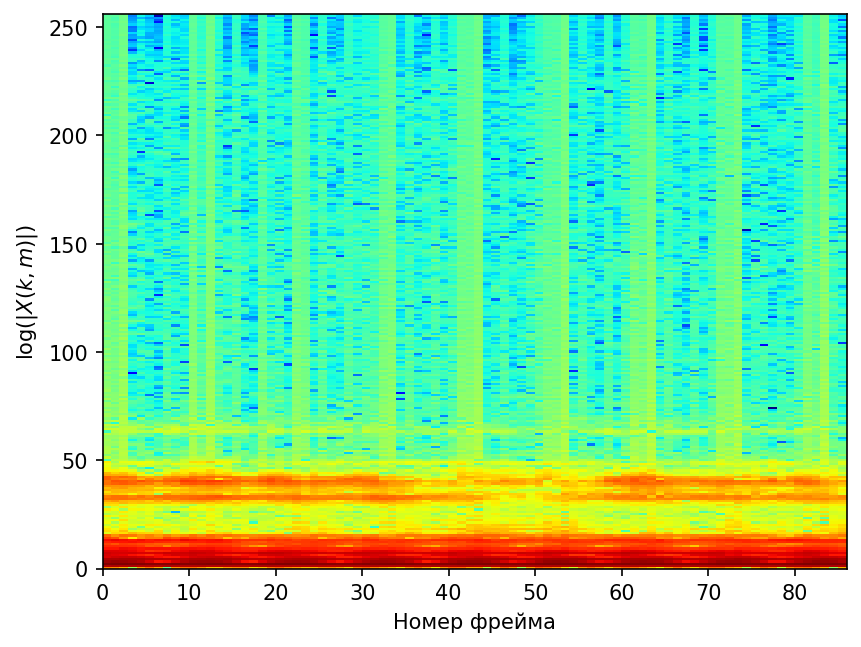

In [7]:
data_sample = X[2153,:,:]
plt.subplots(dpi=150)
plt.pcolor(data_sample,shading='flat',cmap='jet')
plt.xlabel('Номер фрейма')
plt.ylabel('$\log(|X(k,m)|)$')

In [8]:
np.savez('data', X)
np.savez('targets', y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
